<a href="https://colab.research.google.com/gist/ichrakbensaad1/290894207d848833608a2e235890e232/prediction-covid-19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**texte en gras**

#Procédure:

Préparation des exigences

Obtenir l'ensemble de données

Fonctions de préparation

Préparation des données et du modèle

Tester le modèle avant de passer à la prédiction future

Faire des prédictions futures

In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [ ]:
RANDOM_SEED = 42
TRAIN_CASE = "new_cases"
TRAIN_LOCATION = "Tunisia"
DATATRAIN_SOURCE_FILE = "owid-covid-data.csv"
TEST_SIZE = 0.3
LOOK_BACK = 1
BATCH_SIZE = 1
EPOCHS = 2000
DAYS_TO_PREDICT = 30

In [ ]:
df = pd.read_csv('owid-covid-data.csv')
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.025,0.025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.025,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,0.025,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN


In [ ]:
np.random.seed(RANDOM_SEED)


In [ ]:

if TRAIN_LOCATION:
    df = df.loc[df['location']==TRAIN_LOCATION]
df.drop(['location'], axis=1, inplace=True)
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)

In [ ]:
df.head()

,iso_code,continent,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-02,IDN,Asia,2.0,2.0,NaN,NaN,NaN,NaN,0.007,0.007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.70,276361788.0,145.725,29.3,5.319,3.053,11188.744,5.7,342.864,6.32,2.8,76.1,64.204,1.04,71.72,0.718,NaN
2020-03-03,IDN,Asia,2.0,0.0,NaN,NaN,NaN,NaN,0.007,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.04,276361788.0,145.725,29.3,5.319,3.053,11188.744,5.7,342.864,6.32,2.8,76.1,64.204,1.04,71.72,0.718,NaN
2020-03-04,IDN,Asia,2.0,0.0,NaN,NaN,NaN,NaN,0.007,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.04,276361788.0,145.725,29.3,5.319,3.053,11188.744,5.7,342.864,6.32,2.8,76.1,64.204,1.04,71.72,0.718,NaN
2020-03-05,IDN,Asia,2.0,0.0,NaN,NaN,NaN,NaN,0.007,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.04,276361788.0,145.725,29.3,5.319,3.053,11188.744,5.7,342.864,6.32,2.8,76.1,64.204,1.04,71.72,0.718,NaN
2020-03-06,IDN,Asia,4.0,2.0,NaN,NaN,NaN,NaN,0.014,0.007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.04,276361788.0,145.725,29.3,5.319,3.053,11188.744,5.7,342.864,6.32,2.8,76.1,64.204,1.04,71.72,0.718,NaN


In [ ]:
cases = df.filter([TRAIN_CASE])
cases = cases[(cases.T != 0).any()]


In [ ]:
cases.head()

,new_cases
date,
2020-03-02,2.0
2020-03-06,2.0
2020-03-08,2.0
2020-03-09,13.0
2020-03-10,8.0


In [ ]:
cases.shape

(545, 1)

#Tracé des données de cas de train


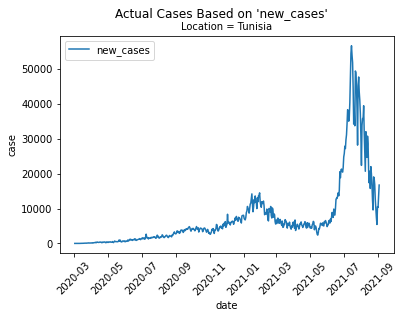

In [ ]:
plt.suptitle('Actual Cases Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION, fontsize='medium')
plt.plot(cases, label=TRAIN_CASE)
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()
plt.show()

# préparation le fonctions 

In [ ]:
def data_split(data, look_back=1):
    x, y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]
        x.append(a)
        y.append(data[i + look_back, 0])
    return np.array(x), np.array(y)

#Preparing data & model

In [ ]:
test_size = TEST_SIZE
test_size = int(cases.shape[0] * test_size)
train_cases = cases[:-test_size]
test_cases = cases[-test_size:]

In [ ]:
train_cases.shape

(382, 1)

In [ ]:

test_cases.shape

(163, 1)

#Data normalization


In [ ]:

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(cases)
all_cases = scaler.transform(cases)
train_cases = scaler.transform(train_cases)
test_cases = scaler.transform(test_cases)

In [ ]:
all_cases.shape

(545, 1)

In [ ]:
train_cases.shape

(382, 1)

In [ ]:
test_cases.shape


(163, 1)

In [ ]:

look_back = LOOK_BACK
X_all, Y_all = data_split(all_cases, look_back=look_back)
X_train, Y_train = data_split(train_cases, look_back=look_back)
X_test, Y_test = data_split(test_cases, look_back=look_back)

LSTM




In [ ]:
X_all = np.array(X_all).reshape(X_all.shape[0], 1, 1)
Y_all = np.array(Y_all).reshape(Y_all.shape[0], 1)
X_train = np.array(X_train).reshape(X_train.shape[0], 1, 1)
Y_train = np.array(Y_train).reshape(Y_train.shape[0], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], 1, 1)
Y_test = np.array(Y_test).reshape(Y_test.shape[0], 1)

batch_size = BATCH_SIZE
model = Sequential()
model.add(LSTM(4, return_sequences=True, 
               batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), 
               stateful=True))
model.add(LSTM(1, stateful=True))
model.add(Dense(Y_train.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

#LSTM timeseries prediction model

In [ ]:
batch_size = BATCH_SIZE
model = Sequential()
model.add(LSTM(4, return_sequences=True, 
               batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), 
               stateful=True))
model.add(LSTM(1, stateful=True))
model.add(Dense(Y_train.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

NameError: ignored

#Testing the model before going to the future prediction

Fitting the model with train data

In [ ]:
epoch = EPOCHS
loss = []
for i in range(epoch):
    print('Iteration ' + str(i + 1) + '/' + str(epoch))
    model.fit(X_train, Y_train, batch_size=batch_size, 
              epochs=1, verbose=1, shuffle=False)
    h = model.history
    loss.append(h.history['loss'][0])
    model.reset_states()

NameError: ignored


Plotting model loss history

Lower loss provide better prediction


In [ ]:
plt.plot(loss, label='loss')
plt.title('Model Loss History')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

Predicting with train data

This will also set predict input (previous input) into LSTM state which is useful to predict future value

In [ ]:
all_predict = model.predict(X_all, batch_size=batch_size)





Predicting future value up to n-days

In our case, we're going to predict up to DAYS_TO_PREDICT days in the future



In [ ]:
days_to_predict = DAYS_TO_PREDICT
future_predict = []
pred_samples = all_predict[-1:]
pred_samples = np.array([pred_samples])
for i in range(days_to_predict):
    pred = model.predict(pred_samples, batch_size=batch_size)
    pred = np.array(pred).flatten()
    future_predict.append(pred)
    new_samples = np.array(pred_samples).flatten()
    new_samples = np.append(new_samples, [pred])
    new_samples = new_samples[1:]
    pred_samples = np.array(new_samples).reshape(1, 1, 1)
future_predict = np.array(future_predict).reshape(len(future_predict), 1, 1)

Reset LSTM input state for safety

In [ ]:
model.reset_states()

Reset LSTM input state for safety

In [ ]:

f_future_predict = model.predict(future_predict, batch_size=batch_size)


Reset LSTM input state for safety



In [ ]:
model.reset_states()


In [ ]:
X_all_flatten = np.array(scaler.inverse_transform(
    np.array(X_all).reshape(X_all.shape[0], 1)
)).flatten().astype('int')
X_all_flatten = np.absolute(X_all_flatten)
Y_all_flatten = np.array(scaler.inverse_transform(
    np.array(Y_all).reshape(Y_all.shape[0], 1)
)).flatten().astype('int')
Y_all_flatten = np.absolute(Y_all_flatten)
all_predict_flatten = np.array(scaler.inverse_transform(
    np.array(all_predict).reshape(all_predict.shape[0], 1)
)).flatten().astype('int')
all_predict_flatten = np.absolute(all_predict_flatten)
future_predict_flatten = np.array(scaler.inverse_transform(
    np.array(future_predict).reshape(future_predict.shape[0], 1)
)).flatten().astype('int')
future_predict_flatten = np.absolute(future_predict_flatten)
f_future_predict_flatten = np.array(scaler.inverse_transform(
    np.array(f_future_predict).reshape(f_future_predict.shape[0], 1)
)).flatten().astype('int')
f_future_predict_flatten = np.absolute(f_future_predict_flatten)


Getting RMSE scores

In [ ]:
all_predict_score = math.sqrt(
    mean_squared_error(
        Y_all_flatten, 
        all_predict_flatten
    )
)

In [ ]:
'All Score: %.2f RMSE' % (all_predict_score)



Generate future index (dates)

In [ ]:
future_index = pd.date_range(start=cases.index[-1], periods=days_to_predict + 1, closed='right')


Plotting future prediction visualization

In [ ]:
plt.plot(
    future_index,
    future_predict_flatten,
    label='prediction cases'
)
plt.suptitle('Future Prediction Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Plotting future prediction visualization



In [ ]:
plt.plot(
    future_index,
    f_future_predict_flatten,
    label='f_prediction cases'
)
plt.suptitle('F_Future Prediction Based on Previous Future Prediction')
plt.title('Location = ' + TRAIN_LOCATION, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()


Plotting f_future prediction visualization

In [ ]:
plt.plot(
    cases.index[:len(X_all_flatten)],
    X_all_flatten,
    label='actual cases'
)
plt.plot(
    cases.index[:len(X_all_flatten)],
    all_predict_flatten,
    label='actual prediction cases'
)
plt.plot(
    future_index,
    future_predict_flatten,
    label='predict up to ' + str(days_to_predict) + ' days in the future'
)
plt.plot(
    future_index,
    f_future_predict_flatten,
    label='f_future based on previous future prediction'
)
plt.suptitle('Future Prediction Based on \'' + TRAIN_CASE + '\'')
plt.title('Location = ' + TRAIN_LOCATION, fontsize='medium')
plt.xlabel('date')
plt.ylabel('case')
plt.xticks(rotation=45)
plt.legend()
plt.show()